# PyNN and Brian examples

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/PyNN.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/PyNN.ipynb)

In [1]:
#!pip install ANNarchy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ANNarchy as ann

ann.setup(dt=0.1)

ANNarchy 4.8 (4.8.3) on linux (posix).


## IF_curr_alpha

Simple network with a Poisson spike source projecting to a pair of IF_curr_alpha neurons.

This is a reimplementation of the PyNN example:

<http://www.neuralensemble.org/trac/PyNN/wiki/Examples/simpleNetwork>

Compiling ...  OK 


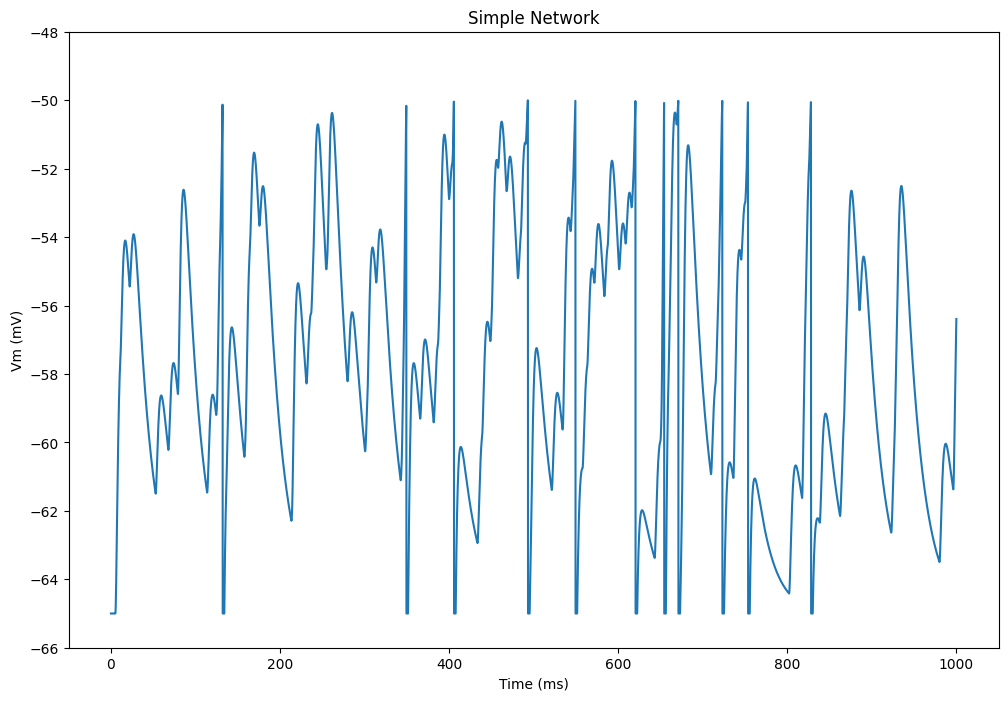

In [2]:
ann.clear()

# Parameters
tstop = 1000.0
rate = 100.0

# Create the Poisson spikes
number = int(2*tstop*rate/1000.0)
np.random.seed(26278342)
spike_times = np.add.accumulate(np.random.exponential(1000.0/rate, size=number))

# Input population
inp  = ann.SpikeSourceArray(list(spike_times))

# Output population
pop = ann.Population(2, ann.IF_curr_alpha)
pop.tau_refrac = 2.0,
pop.v_thresh = -50.0,
pop.tau_syn_E = 2.0,
pop.tau_syn_I = 2.0

# Excitatory projection
proj = ann.Projection(inp, pop, 'exc')
proj.connect_all_to_all(weights=1.0)

# Monitor
m = ann.Monitor(pop, ['spike', 'v'])

# Compile the network
ann.compile()

# Simulate
ann.simulate(tstop)
data = m.get()

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(ann.dt()*np.arange(tstop/ann.dt()), data['v'][:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.ylim([-66.0, -48.0])
plt.title('Simple Network')
plt.show()

## IF_cond_exp

A single IF neuron with exponential, conductance-based synapses, fed by two spike sources.

This is a reimplementation of the PyNN example:

<http://www.neuralensemble.org/trac/PyNN/wiki/Examples/IF_cond_exp>

Compiling ...  OK 


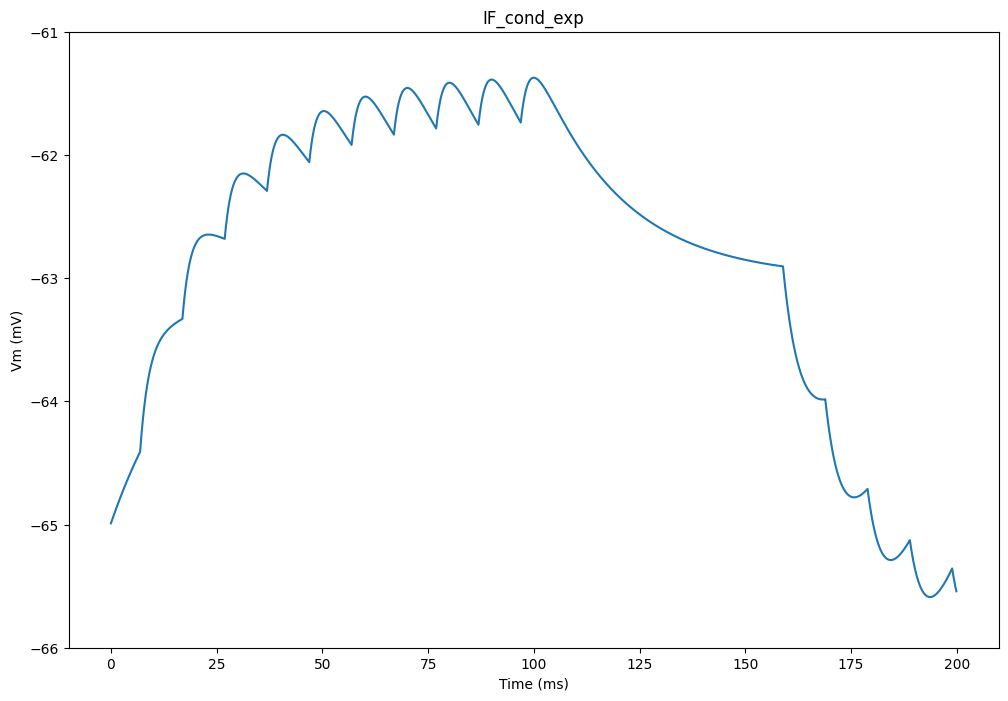

In [3]:
ann.clear()

# Parameters
tstop = 200.0

# Input populations with predetermined spike times
spike_sourceE = ann.SpikeSourceArray(spike_times= [float(i) for i in range(5,105,10)] )
spike_sourceI = ann.SpikeSourceArray(spike_times= [float(i) for i in range(155,255,10)])

# Population with one IF_cond_exp neuron
ifcell = ann.Population(1, ann.IF_cond_exp)
ifcell.set(
    {   'i_offset' : 0.1,    'tau_refrac' : 3.0,
        'v_thresh' : -51.0,  'tau_syn_E'  : 2.0,
        'tau_syn_I': 5.0,    'v_reset'    : -70.0,
        'e_rev_E'  : 0.,     'e_rev_I'    : -80.0 } )


# Projections
connE = ann.Projection(spike_sourceE, ifcell, 'exc')
connE.connect_all_to_all(weights=0.006, delays=2.0)

connI = ann.Projection(spike_sourceI, ifcell, 'inh')
connI.connect_all_to_all(weights=0.02,  delays=4.0)

# Monitor
m = ann.Monitor(ifcell, ['spike', 'v'])

# Compile the network
ann.compile()

# Simulate
ann.simulate(tstop)
data = m.get()

# Show the result
plt.figure(figsize=(12, 8))
plt.plot(ann.dt()*np.arange(tstop/ann.dt()), data['v'][:, 0])
plt.xlabel('Time (ms)')
plt.ylabel('Vm (mV)')
plt.ylim([-66.0, -61.0])
plt.title('IF_cond_exp')
plt.show()

## EIF_cond_exp

Network of EIF neurons with exponentially decreasing conductance-based synapses.

This is a reimplementation of the Brian example:

<http://brian.readthedocs.org/en/1.4.1/examples-misc_expIF_network.html>

Compiling ...  OK 
Simulating 0.5 seconds of the network took 0.2780916690826416 seconds. 


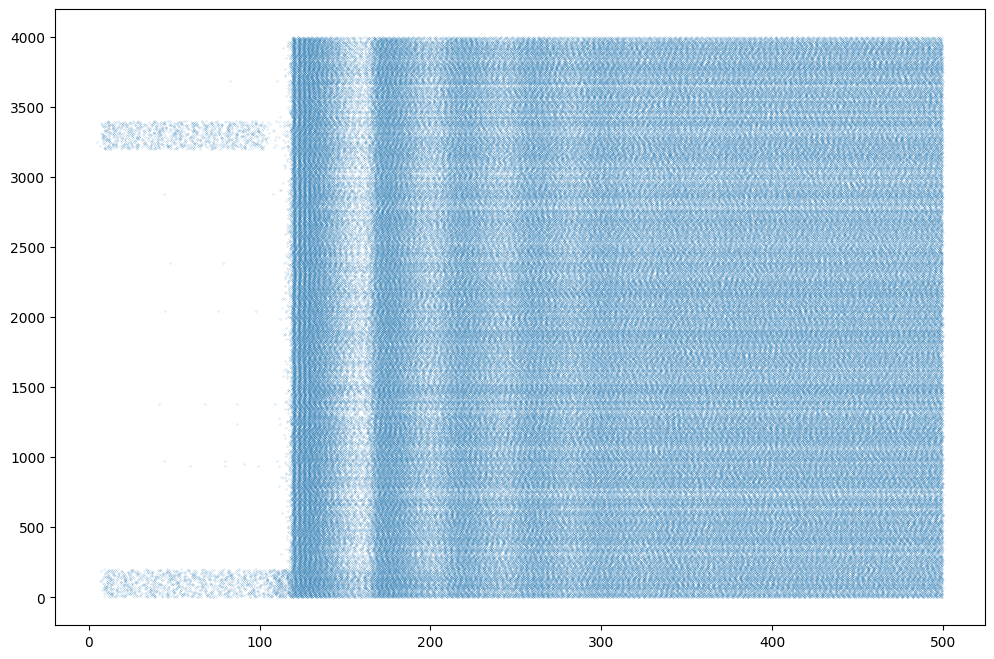

In [4]:
ann.clear()

EIF = ann.Neuron(
    parameters = dict(
        v_rest = -70.0,
        cm = 0.2,
        tau_m = 10.0,
        tau_syn_E = 5.0,
        tau_syn_I = 10.0,
        e_rev_E = 0.0,
        e_rev_I = -80.0,
        delta_T = 3.0,
        v_thresh = -55.0,
        v_reset = -70.0,
        v_spike = -20.0,
    ),
    equations = [
        'dv/dt = (v_rest - v +  delta_T * exp( (v-v_thresh)/delta_T) )/tau_m + ( g_exc * (e_rev_E - v) + g_inh * (e_rev_I - v) )/cm',
        'tau_syn_E * dg_exc/dt = - g_exc',
        'tau_syn_I * dg_inh/dt = - g_inh',
    ],
    spike = "v > v_spike",
    reset = "v = v_reset",
    refractory = 2.0

)

# Poisson inputs
i_exc = ann.PoissonPopulation(geometry=200, rates="if t < 200.0 : 2000.0 else : 0.0")
i_inh = ann.PoissonPopulation(geometry=200, rates="if t < 100.0 : 2000.0 else : 0.0")

# Main population
P = ann.Population(geometry=4000, neuron=EIF)

# Subpopulations
Pe = P[:3200]
Pi = P[3200:]

# Projections
we = 1.5 / 1000.0 # excitatory synaptic weight
wi = 2.5 * we # inhibitory synaptic weight

Ce = ann.Projection(Pe, P, 'exc')
Ce.connect_fixed_probability(weights=we, probability=0.05)

Ci = ann.Projection(Pi, P, 'inh')
Ci.connect_fixed_probability(weights=wi, probability=0.05)

Ie = ann.Projection(i_exc, P[:200], 'exc') # inputs to excitatory cells
Ie.connect_one_to_one(weights=we)

Ii = ann.Projection(i_inh, P[3200:3400], 'exc')# inputs to inhibitory cells
Ii.connect_one_to_one(weights=we)

# Initialization of variables
P.v = -70.0 + 10.0 * np.random.rand(P.size)
P.g_exc = (np.random.randn(P.size) * 2.0 + 5.0) * we
P.g_inh = (np.random.randn(P.size) * 2.0 + 5.0) * wi

# Monitor
m = ann.Monitor(P, 'spike')

# Compile the Network
ann.compile()

# Simulate
ann.simulate(500.0, measure_time=True)

# Retrieve recordings
data = m.get()
t, n = m.raster_plot(data['spike'])

plt.figure(figsize=(12, 8))
plt.plot(t, n, '.', markersize=0.2)
plt.show()

## AEIF_cond_exp

Adaptive exponential integrate-and-fire model.

<http://www.scholarpedia.org/article/Adaptive_exponential_integrate-and-fire_model>

Model introduced in:

> Brette R. and Gerstner W. (2005), Adaptive Exponential Integrate-and-Fire Model as an Effective Description of Neuronal Activity, J. Neurophysiol. 94: 3637 - 3642.

This is a reimplementation of the Brian example:

<https://brian.readthedocs.io/en/stable/examples-frompapers_Brette_Gerstner_2005.html>

Compiling ...  OK 


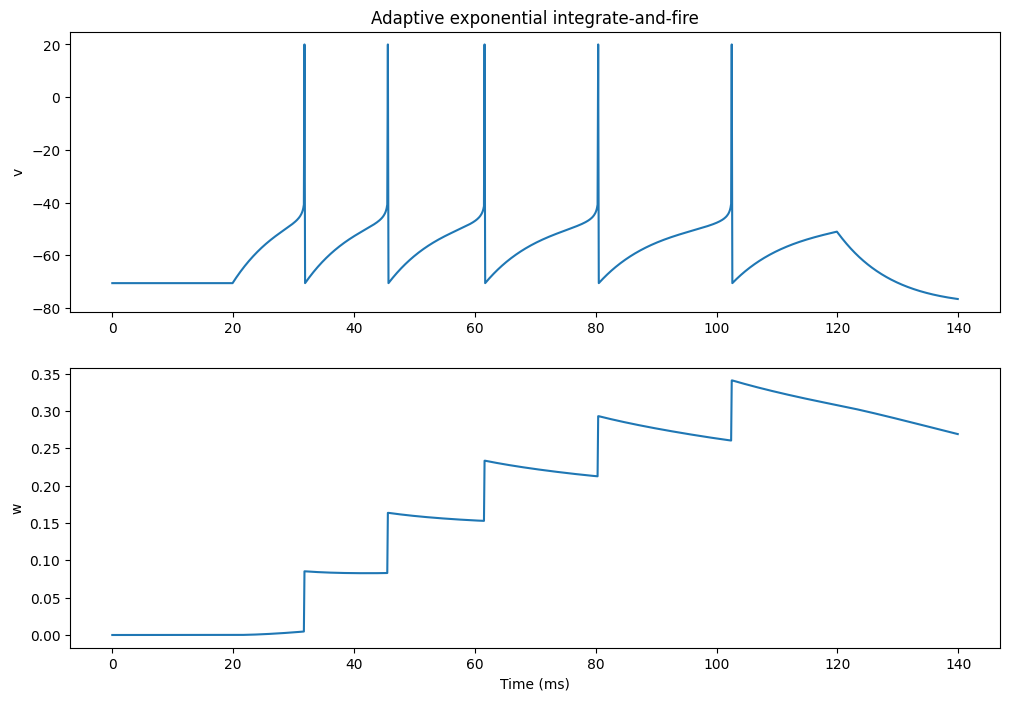

In [5]:
ann.clear()

# Create a population with one AdEx neuron
pop = ann.Population(geometry=1, neuron=ann.EIF_cond_exp_isfa_ista)

# Regular spiking (paper)
pop.tau_w, pop.a, pop.b, pop.v_reset = 144.0,  4.0, 0.0805, -70.6

# Bursting
#pop.tau_w, pop.a, pop.b, pop.v_reset = 20.0, 4.0, 0.5, pop.v_thresh + 5.0

# Fast spiking
#pop.tau_w, pop.a, pop.b, pop.v_reset = 144.0, 2000.0*pop.cm/144.0, 0.0, -70.6

# Monitor
m = ann.Monitor(pop, ['spike', 'v', 'w'])

# Compile the network
ann.compile()


# Add current of 1 nA and simulate
ann.simulate(20.0)
pop.i_offset = 1.0
ann.simulate(100.0)
pop.i_offset = 0.0
ann.simulate(20.0)

# Retrieve the results
data = m.get()
spikes = data['spike'][0]
v = data['v'][:, 0]
w = data['w'][:, 0]
if len(spikes)>0:
    v[spikes] = 20.0

# Plot the activity
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(ann.dt()*np.arange(140.0/ann.dt()), v)
plt.ylabel('v')
plt.title('Adaptive exponential integrate-and-fire')
plt.subplot(2,1,2)
plt.plot(ann.dt()*np.arange(140.0/ann.dt()), w)
plt.xlabel('Time (ms)')
plt.ylabel('w')
plt.show()

## Non-linear synapses

A single IF neuron with two non-linear NMDA synapses.

This is a reimplementation of the Brian example:

<http://brian.readthedocs.org/en/latest/examples-synapses_nonlinear_synapses.html>

Compiling ...  OK 


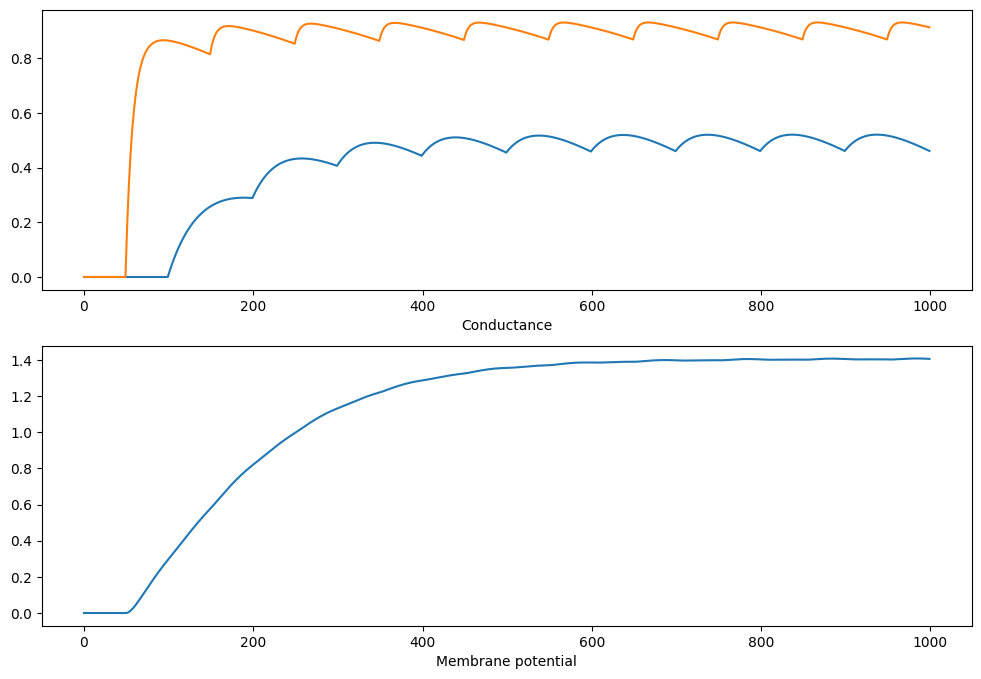

In [6]:
ann.clear()

# Neurons
Linear = ann.Neuron(equations="dv/dt = 0.1", spike="v>1.0", reset="v=0.0")
Integrator = ann.Neuron(equations="dv/dt = 0.1*(g_exc -v)", spike="v>2.0", reset="v=0.0")

# Non-linear synapse
NMDA = ann.Synapse(
    parameters = dict(tau = 10.0),
    equations = [
        'tau * dx/dt = -x',
        'tau * dg/dt = -g +  x * (1 -g)',
    ],
    pre_spike = "x += w",
    psp = "g"
)

# Populations
input = ann.Population(geometry=2, neuron=Linear)
input.v = [0.0, 0.5]
pop = ann.Population(geometry=1, neuron=Integrator)

# Projection
proj = ann.Projection(
    pre=input, post=pop, target='exc',
    synapse=NMDA)
proj.connect_from_matrix(weights=[[1.0, 10.0]])

# Monitors
m = ann.Monitor(pop, 'v')
w = ann.Monitor(proj, 'g')

# Compile the network
ann.compile()

# Simulate for 100 ms
ann.simulate(100.0)

# Retrieve recordings
v = m.get('v')[:, 0]
s = w.get('g')[:, 0, :]

# Plot the recordings
plt.figure(figsize=(12, 8))

plt.subplot(2,1,1)
plt.plot(s[:, 0])
plt.plot(s[:, 1])
plt.xlabel("Time (ms)")
plt.xlabel("Conductance")

plt.subplot(2,1,2)
plt.plot(v)
plt.xlabel("Time (ms)")
plt.xlabel("Membrane potential")
plt.show()

## STP

Network (CUBA) with short-term synaptic plasticity for excitatory synapses (depressing at long timescales, facilitating at short timescales).

Adapted from :

<https://brian.readthedocs.io/en/stable/examples-synapses_short_term_plasticity2.html>

Compiling ...  OK 
Simulating 1.0 seconds of the network took 0.06611371040344238 seconds. 
Total number of spikes: 14309


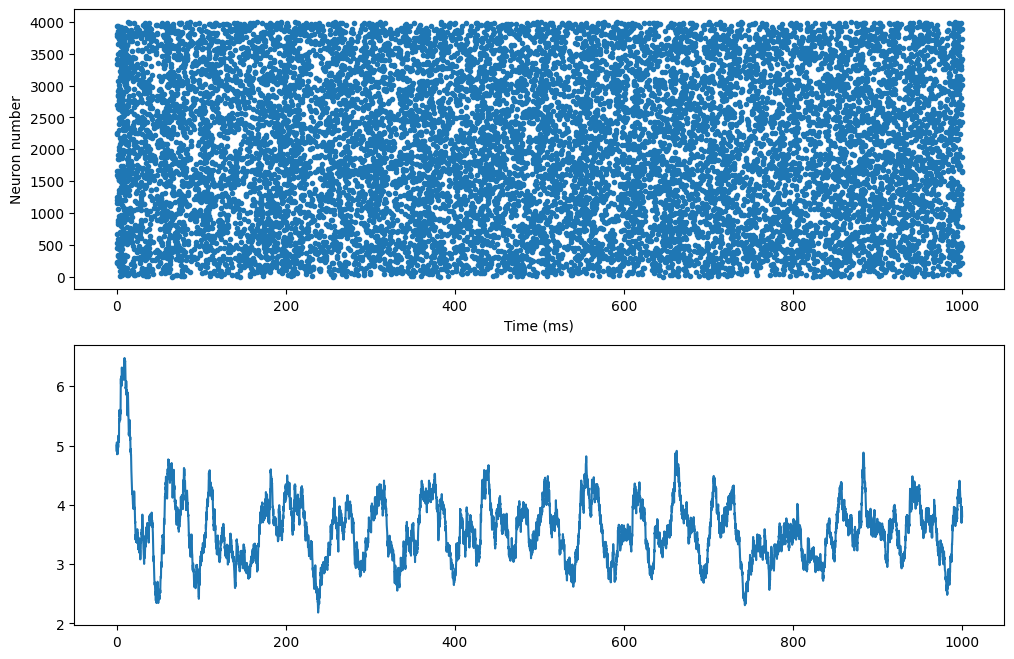

In [7]:
ann.clear()

duration = 1000.0

LIF = ann.Neuron(
    parameters = dict(
        tau_m = 20.0,
        tau_e = 5.0,
        tau_i = 10.0,
        E_rest = -49.0,
        E_thresh = -50.0,
        E_reset = -60.0,
    ),
    equations = [
        'tau_m * dv/dt = E_rest -v + g_exc - g_inh',
        'tau_e * dg_exc/dt = -g_exc',
        'tau_i * dg_inh/dt = -g_inh',
    ],
    spike = "v > E_thresh",
    reset = "v = E_reset"
)

STP = ann.Synapse(
    parameters = dict(
        tau_rec = 200.0,
        tau_facil = 20.0,
        U = 0.2,
    ),
    equations = [
        ann.variable('dx/dt = (1 - x)/tau_rec', init = 1.0, method='event-driven'),
        ann.variable('du/dt = (U - u)/tau_facil', init = 0.2, method='event-driven'),
    ],
    pre_spike = """
        g_target += w * u * x
        x *= (1 - u)
        u += U * (1 - u)
    """
)

# Population
P = ann.Population(geometry=4000, neuron=LIF)
P.v = ann.Uniform(-60.0, -50.0)
Pe = P[:3200]
Pi = P[3200:]

# Projections
con_e = ann.Projection(pre=Pe, post=P, target='exc', synapse = STP)
con_e.connect_fixed_probability(weights=1.62, probability=0.02)

con_i = ann.Projection(pre=Pi, post=P, target='inh')
con_i.connect_fixed_probability(weights=9.0, probability=0.02)

# Monitor
m = ann.Monitor(P, 'spike')

# Compile the network
ann.compile()

# Simulate without plasticity
ann.simulate(duration, measure_time=True)

data = m.get()
t, n = m.raster_plot(data['spike'])
rates = m.population_rate(data['spike'], 5.0)
print('Total number of spikes: ' + str(len(t)))

plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(t, n, '.')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron number')
plt.subplot(212)
plt.plot(np.arange(rates.size)*ann.dt(), rates)
plt.show()